## Description:
这里是DIEN的一个demo， 主要分为数据读取与处理，模型搭建，模型的训练三大模块

In [1]:
# python基础包
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 导入模型
from DIEN import DIEN

# 模型训练相关
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## 导入数据

In [2]:
"""读取数据"""
samples_data = pd.read_csv("data/movie_sample.txt", sep="\t", header = None)
samples_data.columns = ["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id", "label"]

In [3]:
"""数据集"""
X = samples_data[["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id"]]
y = samples_data["label"]

# 这里设置个负采样数据， 目前是直接等于了hist_movie_id
X['neg_hist_movie_id'] = X['hist_movie_id']
behavior_len = np.array([len([int(i) for i in l.split(',') if int(i) != 0]) for l in X['hist_movie_id']])

In [4]:
"""构建DIEN模型的输入格式"""
# 这里和DIN相比， 会多出负采样的一列历史行为

X_train = {"user_id": np.array(X["user_id"]), \
        "gender": np.array(X["gender"]), \
        "age": np.array(X["age"]), \
        "hist_movie_id": np.array([[int(i) for i in l.split(',')] for l in X["hist_movie_id"]]), \
        "neg_hist_movie_id": np.array([[int(i) for i in l.split(',')] for l in X["neg_hist_movie_id"]]), \
        "seq_length": behavior_len, \
        "hist_len": np.array(X["hist_len"]), \
        "movie_id": np.array(X["movie_id"]), \
        "movie_type_id": np.array(X["movie_type_id"])}

y_train = np.array(y)

## 模型建立

In [5]:
"""特征封装"""

feature_columns = [SparseFeat('user_id', max(samples_data["user_id"])+1, embedding_dim=8), 
                    SparseFeat('gender', max(samples_data["gender"])+1, embedding_dim=8), 
                    SparseFeat('age', max(samples_data["age"])+1, embedding_dim=8), 
                    SparseFeat('movie_id', max(samples_data["movie_id"])+1, embedding_dim=8),
                    SparseFeat('movie_type_id', max(samples_data["movie_type_id"])+1, embedding_dim=8),
                    DenseFeat('hist_len', 1)]
feature_columns += [VarLenSparseFeat(SparseFeat('hist_movie_id', 
                                                vocabulary_size=max(samples_data["movie_id"])+1,
                                                embedding_dim=8,
                                                embedding_name='item_id'), maxlen=50, length_name='seq_length')]
feature_columns += [VarLenSparseFeat(SparseFeat('neg_hist_movie_id', 
                                                vocabulary_size=max(samples_data["movie_id"])+1,
                                                embedding_dim=8,
                                                embedding_name='item_id'), maxlen=50, length_name='seq_length')]

# 行为特征列表，表示的是基础特征
behavior_feature_list = ['movie_id']
# 行为序列特征
behavior_seq_feature_list = ['hist_movie_id']

In [6]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 64
epochs = 50

In [7]:
"""构建DIN模型"""
model = DIEN(feature_columns, behavior_feature_list, behavior_seq_feature_list, use_neg_sample=True)
model.summary()

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hist_movie_id (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
emb_hist_movie_id (Embedding)   (None, 50, 8)        1680        hist_movie_id[0][0]              
_____

In [8]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=[AUC()])

## 模型训练

In [9]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)  # 调整学习率
]
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    validation_split=0.2, 
                    batch_size=batch_size,
                    callbacks = callbacks
                   )

Train on 1104 samples, validate on 276 samples
Epoch 1/50
1104/1104 [==============================] - 2s 2ms/sample - loss: 1.5078 - auc: 0.4850 - val_loss: 0.8970 - val_auc: 0.4973
Epoch 2/50
1104/1104 [==============================] - 1s 692us/sample - loss: 0.9351 - auc: 0.4893 - val_loss: 0.7694 - val_auc: 0.4897
Epoch 3/50
1104/1104 [==============================] - 1s 711us/sample - loss: 0.7740 - auc: 0.5129 - val_loss: 0.6684 - val_auc: 0.4778
Epoch 4/50
1104/1104 [==============================] - 1s 764us/sample - loss: 0.7067 - auc: 0.4821 - val_loss: 0.6581 - val_auc: 0.3171
Epoch 5/50
1104/1104 [==============================] - 1s 716us/sample - loss: 0.6671 - auc: 0.4975 - val_loss: 0.6169 - val_auc: 0.2777
Epoch 6/50
1104/1104 [==============================] - 1s 765us/sample - loss: 0.6672 - auc: 0.4989 - val_loss: 0.6042 - val_auc: 0.3402
Epoch 7/50
1104/1104 [==============================] - 1s 726us/sample - loss: 0.6385 - auc: 0.4944 - val_loss: 0.6024 - val_a

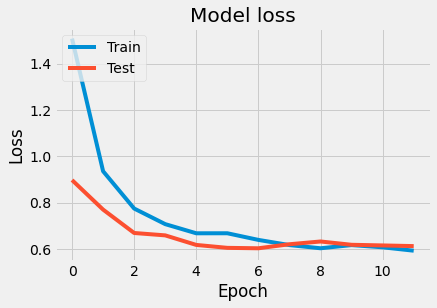

In [10]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()